# MIE1624 - Assignment 1  

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import re, nltk
from nltk.stem import *
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
!pip install whoosh
from whoosh import index, writing, scoring
from whoosh.fields import Schema, TEXT, KEYWORD, ID, STORED
from whoosh.analysis import *
from whoosh.qparser import QueryParser
import os, os.path
import shutil
from collections import Counter
import string
!pip install wordcloud
from wordcloud import WordCloud
import seaborn as sns
from scipy import stats
#################################################################
from html.parser import HTMLParser

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

/Users/Sharon/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# 1. Data cleaning

######    The tweets, as given, are not in a form amenable to analysis -- there is too much ‘noise’. Therefore, the first step is to “clean” the data. Design a procedure that prepares the Twitter data for analysis by satisfying the requirements below.
    All html tags and attributes (i.e., /<[^>]+>/) are removed.
    Html character codes (i.e., &...;) are replaced with an ASCII equivalent.
    All URLs are removed.
    All characters in the text are in lowercase.
    All stopwords are removed. Be clear in what you consider as a stopword. 
    If a tweet is empty after pre-processing, it should be preserved as such.

In [2]:
# import stopword and wordnet package
from nltk.corpus import stopwords
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Sharon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Sharon/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
generic_file = open('generic_tweets.txt', "r", encoding = 'utf-8')
original_tweets = generic_file.readlines()
original_tweets

['"class","id","date","query","user","text"\n',
 '"0","1467810369","Mon Apr 06 22:19:45 PDT 2009","NO_QUERY","_TheSpecialOne_","@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D"\n',
 '"0","1467810672","Mon Apr 06 22:19:49 PDT 2009","NO_QUERY","scotthamilton","is upset that he can\'t update his Facebook by texting it... and might cry as a result  School today also. Blah!"\n',
 '"0","1467810917","Mon Apr 06 22:19:53 PDT 2009","NO_QUERY","mattycus","@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds"\n',
 '"0","1467811184","Mon Apr 06 22:19:57 PDT 2009","NO_QUERY","ElleCTF","my whole body feels itchy and like its on fire "\n',
 '"0","1467811193","Mon Apr 06 22:19:57 PDT 2009","NO_QUERY","Karoli","@nationwideclass no, it\'s not behaving at all. i\'m mad. why am i here? because I can\'t see you all over there. "\n',
 '"0","1467811372","Mon Apr 06 22:20:00 PDT 2009","NO_QUERY","joy_wolf

In [4]:
def dataCleaning(tweet_list):
    """
        The function is used to process cleaning data.
            - removing all html tags and attributes.
            - replacing Html character codes with ASCII
            - removing all URLs
            - Lowercse all characters in the text
            - Removing all the stopwords
            - Preserved Empty tweet
    """
    stopWords_file = open("stop_words.txt", "r", encoding = 'utf-8')
    stopWords_list = stopWords_file.readlines()
    
    stop_words = stopwords.words("english") + [stopWords_list]
    tokenizer = RegexpTokenizer(r'\w+')
    for i in range(len(tweet_list)):
        # removing all html tags
#         from bs4 import BeautifulSoup
#         tweet_list[i] = BeautifulSoup(tweet_list[i], "lxml").text
        cleantext = re.compile('<.*?>')
        tweet_list[i] = re.sub(cleantext, '', tweet_list[i]) 
        
        #replacing Html character codes with ASCII
        html = HTMLParser()
        tweet_list[i] = html.unescape(tweet_list[i])
    
        #removing all URLs
#         tweet_list[i] = re.sub(r'^https?:\/\/.*[\r\n]*', '', tweet_list[i], flags=re.MULTILINE)
#         tweet_list[i] = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '',  tweet_list[i])
        tweet_list[i] = re.sub('(\s+\S+.[^\s]+/\S+)','',tweet_list[i])
        tweet_list[i] = re.sub('(\s+\S+.ca)','',tweet_list[i])
        tweet_list[i] = re.sub('(\s+\S+.uk)','',tweet_list[i])

        #Lowercse all characters in the text
        tweet_list[i] = tweet_list[i].lower()
        
        #Remove some special characters
        emoji_pattern = re.compile(u"(\ud83d[\ude00-\ude4f])|"  # emoticons
                                u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
                                u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
                                u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
                                u"(\ud83c[\udde0-\uddff])"  # flags (iOS)
                                "+", flags=re.UNICODE)
        tweet_list[i] = emoji_pattern.sub(r'', tweet_list[i])
        tweet_list[i] = re.sub('[âœðÿˆïº]','',tweet_list[i])
        
        #Removing all the stopwords
        word_list = tokenizer.tokenize(tweet_list[i])
        filter_words = [word for word in word_list if word not in stop_words]  
        tweet_list[i] = filter_words
        tweet_list[i] = " ".join(tweet_list[i])

    return tweet_list

In [5]:
# open and read generic_tweets.txt
generic_file = open('generic_tweets.txt', "r")
generic_tweet_list = generic_file.readlines()
del generic_tweet_list[0] # delete first element
del generic_tweet_list[-1] # delete last element

In [6]:
# go through the list of tweet, store every column into a specific list
generic_tweets_class = [tw.split(',')[:][0].strip('"') for tw in generic_tweet_list]
generic_tweets_id = [tw.split(',')[:][1].strip('"') for tw in generic_tweet_list]
generic_tweets_date = [tw.split(',')[:][2].strip('"') for tw in generic_tweet_list]
generic_tweets_query = [tw.split(',')[:][3].strip('"') for tw in generic_tweet_list]
generic_tweets_user = [tw.split(',')[:][4].strip('"') for tw in generic_tweet_list]
generic_tweets_text = [tw.split(',')[:][5].strip('"') for tw in generic_tweet_list]

In [7]:
# Do dataCleaning to every column list
generic_cleaned_tweet_class = dataCleaning(generic_tweets_class)
generic_cleaned_tweet_id = dataCleaning(generic_tweets_id)
generic_cleaned_tweet_date = dataCleaning(generic_tweets_date)
generic_cleaned_tweet_query = dataCleaning(generic_tweets_query)
generic_cleaned_tweet_user = dataCleaning(generic_tweets_user)
generic_cleaned_tweet_text = dataCleaning(generic_tweets_text)

/Users/Sharon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


In [8]:
# Create a dataframe for Generic tweet document
import pandas as pd
generic_tweet_df_clean = pd.DataFrame ({
        'class': generic_cleaned_tweet_class,
        'id': generic_cleaned_tweet_id,
        'date': generic_cleaned_tweet_date,
        'query': generic_cleaned_tweet_query,
        'user': generic_cleaned_tweet_user,
        'text': generic_cleaned_tweet_text
})

generic_tweet_df_clean.head()

,class,id,date,query,user,text
0,0,1467810369,mon apr 06 22 19 45 pdt 2009,no_query,_thespecialone_,switchfoot awww
1,0,1467810672,mon apr 06 22 19 49 pdt 2009,no_query,scotthamilton,upset thatn update facebook texting might cry ...
2,0,1467810917,mon apr 06 22 19 53 pdt 2009,no_query,mattycus,kenichan dived many times ball managed save 50...
3,0,1467811184,mon apr 06 22 19 57 pdt 2009,no_query,ellectf,whole body feels itchy like fire
4,0,1467811193,mon apr 06 22 19 57 pdt 2009,no_query,karoli,nationwideclass


In [9]:
# Read 'US_airline_tweets.csv' and store it into a dataframe
US_airline_tweet_df = pd.read_csv('US_airline_tweets.csv', sep=',', encoding='utf-8')
US_airline_tweet_df.head(100)

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,@VirginAmerica plus you've added commercials t...
1,5.703010e+17,negative,Bad Flight,jnardino,0,@VirginAmerica it's really aggressive to blast...
2,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica and it's a really big bad thing...
3,5.703010e+17,negative,Can't Tell,jnardino,0,@VirginAmerica seriously would pay $30 a fligh...
4,5.703010e+17,positive,NaN,cjmcginnis,0,"@VirginAmerica yes, nearly every time I fly VX..."
5,5.703000e+17,positive,NaN,dhepburn,0,"@virginamerica Well, I didn'tâ€¦but NOW I DO! :-D"
6,5.702950e+17,positive,NaN,YupitsTate,0,"@VirginAmerica it was amazing, and arrived an ..."
7,5.702900e+17,positive,NaN,HyperCamiLax,0,@VirginAmerica I &lt;3 pretty graphics. so muc...
8,5.702900e+17,positive,NaN,HyperCamiLax,0,@VirginAmerica This is such a great deal! Alre...
9,5.702870e+17,positive,NaN,mollanderson,0,@VirginAmerica @virginmedia I'm flying your #f...


In [10]:
# Do data Cleaning for every column in US_airline dataframe
US_airline_clean_tweet_id = US_airline_tweet_df.iloc[:]['id']
US_airline_clean_tweet_sentiment = dataCleaning(US_airline_tweet_df.iloc[:]['sentiment'].tolist())
US_airline_clean_tweets_neg_reas = US_airline_tweet_df.iloc[:]['negative_reason']
US_airline_clean_tweets_user = dataCleaning(US_airline_tweet_df.iloc[:]['user'].tolist())
US_airline_clean_tweets_retw_cnt = US_airline_tweet_df.iloc[:]['retweet_count']
US_airline_clean_tweets_text = dataCleaning(US_airline_tweet_df.iloc[:]['text'].tolist())

/Users/Sharon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


In [11]:
#Create a new dataframe for the cleaned us_airline tweets set
us_airline_tweet_df_clean = pd.DataFrame ({
        'id': US_airline_clean_tweet_id,
        'sentiment': US_airline_clean_tweet_sentiment,
        'negative_reason': US_airline_clean_tweets_neg_reas,
        'user': US_airline_clean_tweets_user,
        'retweet_count': US_airline_clean_tweets_retw_cnt,
        'text': US_airline_clean_tweets_text
})

us_airline_tweet_df_clean.head()

,id,sentiment,negative_reason,user,retweet_count,text
0,5.703010e+17,positive,NaN,jnardino,0,virginamerica plus added commercials experienc...
1,5.703010e+17,negative,Bad Flight,jnardino,0,virginamerica really aggressive blast obnoxiou...
2,5.703010e+17,negative,Can't Tell,jnardino,0,virginamerica really big bad thing
3,5.703010e+17,negative,Can't Tell,jnardino,0,virginamerica seriously would pay 30 flight se...
4,5.703010e+17,positive,NaN,cjmcginnis,0,virginamerica yes nearly every time fly vx ear...


In [12]:
# get the total number of lines in US_airline_tweet_df
US_airline_tweet_df.shape[0]

11541

# 2. Exploratory analysis

In [13]:
def find_us_airline(us_airline_tweet_df):
    """
        The function is used to find the airlines names shown up in 'text' column of us_aieline DF.
        and the name of airline always followed with @ or # symbols. 
        Therefore, we need to extract the text after @ and # symbols.
    """
    list_airline = []
    for text in us_airline_tweet_df['text']:
        sp_text = text.split(' ')
        for word in sp_text:
            if "@" in word:
                if word not in list_airline: 
                    list_airline.append(word.lower())
                    continue
            if "#" in word:
                if word not in list_airline: 
                    list_airline.append(word.lower())
                    continue
            
    return list_airline

In [14]:
# return a list of airline company "keywords"
airlines = find_us_airline(US_airline_tweet_df)

In [15]:
airlines

['@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '@australia',
 '@virginamerica',
 '@virginmedia',
 '#fabulous',
 '#seductive',
 '#stress',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '#29daystogo',
 '@virginamerica',
 '@virginamerica.',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '#fail',
 '@virginamerica',
 '#vx358',
 '#noair',
 '#worstflightever',
 '#roasted',
 '#sfotobos',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '@pacificbiznews',
 '@virginamerica',
 '#moodlitmonday',
 '@virginamerica',
 '@freddieawards',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '@virginamerica',
 '#elevategold',
 '@virginamerica',
 '@virginamerica',
 '@ladygaga',
 '@carrieunderwood',
 '@carrieunderwood',
 '@virginamerica',
 '@virginamerica',
 '#guiltypleasu

In [16]:
# Do data cleaning with raw airline keywords
clean_airline = dataCleaning(airlines)

/Users/Sharon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


In [17]:
clean_airline

['virginamerica',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'australia',
 'virginamerica',
 'virginmedia',
 'fabulous',
 'seductive',
 'stress',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 '29daystogo',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'fail',
 'virginamerica',
 'vx358',
 'noair',
 'worstflightever',
 'roasted',
 'sfotobos',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'pacificbiznews',
 'virginamerica',
 'moodlitmonday',
 'virginamerica',
 'freddieawards',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'virginamerica',
 'elevategold',
 'virginamerica',
 'virginamerica',
 'ladygaga',
 'carrieunderwood',
 'carrieunderwood',
 'virginamerica',
 'virginamerica',
 'guiltypleasures',
 'virginamerica',
 'virginamerica',
 'virginamerica

In [18]:
len(clean_airline)

11690

In [19]:
# set up a counter for airline company "keyword", we can get the frequency for each word 
from collections import Counter
counts = Counter(clean_airline)
print(counts)

Counter({'usairways': 2543, 'americanair': 2429, 'southwestair': 1758, 'jetblue': 1497, 'virginamerica': 330, 'united': 127, 'delta': 54, 'unitedairlines': 32, 'destinationdragons': 25, 'americanairlines': 23, '': 21, 'imaginedragons': 17, 'phlairport': 17, 'fail': 16, 'neveragain': 11, 'fortunemagazine': 10, 'cancelled': 8, 'cnn': 8, 'spiritairlines': 8, 'dca': 8, 'dfw': 7, 'cowboycerrone': 7, 'oscars': 6, 'dulles_airport': 6, 'virginatlantic': 6, 'aircanada': 6, 'southwest': 6, 'flyfi': 6, 'lax': 6, 'wsj': 6, 'phl': 5, 'frustrated': 5, 'disappointed': 5, 'badcustomerservice': 5, 'bwi': 5, 'expedia': 5, 'customerservice': 4, 'smh': 4, 'love': 4, 'boston': 4, 'wtf': 4, 'silverairways': 4, '22 keep': 4, 'ewr': 4, 'denver': 4, 'epicfail': 4, 'worstairlineever': 4, 'tsa': 4, 'nothappy': 4, 'newyork': 4, 'dobetter': 4, 'ny_njairports': 4, 'swa': 4, 'aa': 4, 'jfk': 4, 'mint': 4, 'kylejudah': 4, 'jvmchat': 4, 'flydelta': 4, 'aa2444': 4, 'redcarpet': 3, 'sfo': 3, 'help': 3, 'faanews': 3, 'tha

In [20]:
#pick the top 7 company, and then add "others" selection in the list
airlines_company = ['usairways','virginamerica', 'jetblue', 'southwestair', 'united', 'americanair', 'delta', 'others']

In [21]:
def fineNumOfTweetRelatedAirline(us_airline_tweet_df, airlines_company):
    """
        The function is used to find the number of tweets related to each airlines.
        we need to set every airline_company keyword as target, 
        if the tweet's text contains the airline name we could increment the counter for that airline,
    """
    # create a list of counter for different airlines
    list_numTweetRelated = {}
    # initalize the dictionay
    for item in airlines_company:
        list_numTweetRelated[item] = 0
    # loop through the dataframe
    for text in us_airline_tweet_df['text']:
        sp_text = text.split(' ')
        if airlines_company[0] in sp_text:
            list_numTweetRelated[airlines_company[0]] = list_numTweetRelated[airlines_company[0]] + 1
            continue
        elif airlines_company[1] in sp_text:
            list_numTweetRelated[airlines_company[1]] = list_numTweetRelated[airlines_company[1]] + 1
            continue
        elif airlines_company[2] in sp_text:
            list_numTweetRelated[airlines_company[2]] = list_numTweetRelated[airlines_company[2]] + 1
            continue
        elif airlines_company[3] in sp_text:
            list_numTweetRelated[airlines_company[3]] = list_numTweetRelated[airlines_company[3]] + 1
            continue
        elif airlines_company[4] in sp_text:
            list_numTweetRelated[airlines_company[4]] = list_numTweetRelated[airlines_company[4]] + 1
            continue
        elif airlines_company[5] in sp_text:
            list_numTweetRelated[airlines_company[5]] = list_numTweetRelated[airlines_company[5]] + 1
            continue
        elif airlines_company[6] in sp_text:
            list_numTweetRelated[airlines_company[6]] = list_numTweetRelated[airlines_company[6]] + 1
            continue
        else:
            list_numTweetRelated[airlines_company[7]] = list_numTweetRelated[airlines_company[7]] + 1
            continue
            
    return list_numTweetRelated

In [22]:
# return the list of counter for every airlines
result = fineNumOfTweetRelatedAirline(us_airline_tweet_df_clean, airlines_company)

In [23]:
result

{'usairways': 2463,
 'virginamerica': 321,
 'jetblue': 1494,
 'southwestair': 1736,
 'united': 3095,
 'americanair': 2125,
 'delta': 3,
 'others': 304}

Text(0.5,1,'The distribution of the US airlines of the US_airline_tweets')

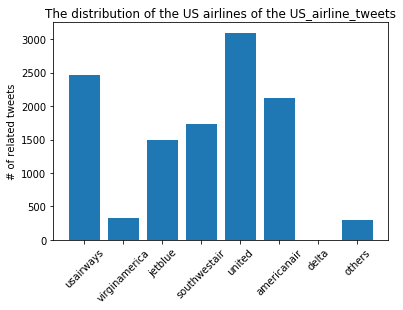

In [24]:
# plot a bar chat for the result
l = range(len(result.keys()))
plt.bar(l, result.values(), align='center')
plt.xticks(l, result.keys(),rotation=45)
plt.ylabel('# of related tweets')
plt.title('The distribution of the US airlines of the US_airline_tweets')

The distribution results of the US airlines of the US_airline_tweets demonstrate that top 3 number of tweets are identified as united, usairways and americanair. Number of tweets about delta is very small. The reason for why others class have lots of tweets is that there might be other airlines lists in tweet, and other solution is that improve the data cleaning function, make the words more cleaning.

-------Present a graphical figure that visualizes another figure for the US airline tweets--------

In [25]:
us_airline_tweet_df_clean['sentiment'][0]

'positive'

In [26]:
def fineTweetRelatedAirline(us_airline_tweet_df, airlines_company):
    """
        The function is used to find the number of tweets related to each airlines 
        and counts positive/negative tweets number.
        we need to set every airline_company keyword as target, 
        if the tweet's text contains the airline name we could check the sentiment of that tweet.
        if it is positive increment the counter for positive, 
        otherwise increment the negative counter for that airline.
    """
    
    # Create dictinaries for all the airline companys, and only two keys inside the dict
    usairways_df = {'positive': 0,'negative': 0}
    virginamerica_df = {'positive': 0,'negative': 0}
    jetblue_df = {'positive':0 ,'negative': 0}
    southwestair_df = {'positive': 0,'negative':0}
    united_df = {'positive': 0,'negative': 0}
    americanair_df = {'positive': 0,'negative': 0}
    delta_df = {'positive': 0,'negative': 0}

    for i in range(len(us_airline_tweet_df['text'])):
        sp_text = us_airline_tweet_df['text'][i].split(' ')
        if airlines_company[0] in sp_text:
            if us_airline_tweet_df['sentiment'][i] == 'positive':
                usairways_df['positive'] = usairways_df['positive'] +1
            else:
                usairways_df['negative'] = usairways_df['negative'] +1
            continue
        elif airlines_company[1] in sp_text:
            if us_airline_tweet_df['sentiment'][i] == 'positive':
                virginamerica_df['positive'] = virginamerica_df['positive'] +1
            else:
                virginamerica_df['negative'] = virginamerica_df['negative'] +1
            continue
        elif airlines_company[2] in sp_text:
            if us_airline_tweet_df['sentiment'][i] == 'positive':
                jetblue_df['positive'] = jetblue_df['positive'] +1
            else:
                jetblue_df['negative'] = jetblue_df['negative'] +1
            continue
        elif airlines_company[3] in sp_text:
            if us_airline_tweet_df['sentiment'][i] == 'positive':
                southwestair_df['positive'] = southwestair_df['positive'] +1
            else:
                southwestair_df['negative'] = southwestair_df['negative'] +1
            continue
        elif airlines_company[4] in sp_text:
            if us_airline_tweet_df['sentiment'][i] == 'positive':
                united_df['positive'] = united_df['positive'] +1
            else:
                united_df['negative'] = united_df['negative'] +1
            continue
        elif airlines_company[5] in sp_text:
            if us_airline_tweet_df['sentiment'][i] == 'positive':
                americanair_df['positive'] = americanair_df['positive'] +1
            else:
                americanair_df['negative'] = americanair_df['negative'] +1
            continue
        elif airlines_company[6] in sp_text:
            if us_airline_tweet_df['sentiment'][i] == 'positive':
                delta_df['positive'] = delta_df['positive'] +1
            else:
                delta_df['negative'] = delta_df['negative'] +1
            continue
            
    return usairways_df, virginamerica_df, jetblue_df, southwestair_df, united_df, americanair_df, delta_df

In [27]:
# return those dict for airlines
usairways_df, virginamerica_df, jetblue_df, southwestair_df, united_df, americanair_df, delta_df = fineTweetRelatedAirline(us_airline_tweet_df_clean, airlines_company)

In [28]:
usairways_df

{'positive': 265, 'negative': 2198}

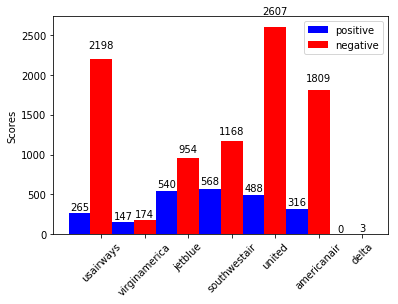

In [29]:
#plot the bar diagram of those dicts, red is for negative tweets number, blue is for positive tweets number
N = 7
ind = np.arange(N)  # the x locations for the groups
width = 0.5       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
yvals = [usairways_df['positive'],virginamerica_df['positive'],jetblue_df['positive'],southwestair_df['positive'],united_df['positive'],americanair_df['positive'], delta_df['positive']]
rects1 = ax.bar(ind, yvals, width, color='b')
zvals = [usairways_df['negative'],virginamerica_df['negative'],jetblue_df['negative'],southwestair_df['negative'],united_df['negative'],americanair_df['negative'], delta_df['negative']]
rects2 = ax.bar(ind+width, zvals, width, color='r')

ax.set_ylabel('Scores')
ax.set_xticks(ind+width)
ax.set_xticklabels( ('usairways', 'virginamerica', 'jetblue', 'southwestair', 'united', 'americanair', 'delta'), rotation=45)
ax.legend( (rects1[0], rects2[0]), ('positive', 'negative') )

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

5. Discussion Question: Explain how each airline is viewed in the public eye based on the sentiment value.

we can see from the diagram, all the airlines got more negative feedbacks than positive. Usairways, united and americanair are the top three negative tweets recievers and all of them have very less positive tweets. compare to others airlines, virginamerica airline has a better performance than other companies. Delta get fewest tweets and all of them are negative. jetblue and southwestair also have more tweets which is negative. they are in the middle level of all the airlines.

##### Generic tweets Visualization

Present a graphical figure (histogram) that visualizes some aspect of the generic tweets 

In [30]:
generic_tweet_df_clean.head()

,class,id,date,query,user,text
0,0,1467810369,mon apr 06 22 19 45 pdt 2009,no_query,_thespecialone_,switchfoot awww
1,0,1467810672,mon apr 06 22 19 49 pdt 2009,no_query,scotthamilton,upset thatn update facebook texting might cry ...
2,0,1467810917,mon apr 06 22 19 53 pdt 2009,no_query,mattycus,kenichan dived many times ball managed save 50...
3,0,1467811184,mon apr 06 22 19 57 pdt 2009,no_query,ellectf,whole body feels itchy like fire
4,0,1467811193,mon apr 06 22 19 57 pdt 2009,no_query,karoli,nationwideclass


In [31]:
# split a list containing tweets into a list containing words
def splitToWords(list_tweet):
    word_list = []
    for i in range(len(list_tweet)):
        templist = list_tweet[i].split()
        for word in templist:
            word_list.append(word)
    return word_list

In [32]:
# return a word list for generic tweets(only for "text" column)
generic_tweet_word_list = splitToWords(generic_tweet_df_clean['text'])

In [33]:
generic_tweet_word_list

['switchfoot',
 'awww',
 'upset',
 'thatn',
 'update',
 'facebook',
 'texting',
 'might',
 'cry',
 'result',
 'school',
 'today',
 'also',
 'blah',
 'kenichan',
 'dived',
 'many',
 'times',
 'ball',
 'managed',
 'save',
 '50',
 'rest',
 'go',
 'bounds',
 'whole',
 'body',
 'feels',
 'itchy',
 'like',
 'fire',
 'nationwideclass',
 'kwesidei',
 'whole',
 'crew',
 'need',
 'hug',
 'loltrish',
 'hey',
 'long',
 'time',
 'see',
 'yes',
 'rains',
 'bit',
 'tatiana_k',
 'nope',
 'twittera',
 'que',
 'muera',
 'spring',
 'break',
 'plain',
 'city',
 'snowing',
 'pierced',
 'ears',
 'caregiving',
 'bear',
 'watch',
 'thought',
 'ua',
 'loss',
 'embarrassing',
 'octolinz16',
 'counts',
 'smarrison',
 'would',
 'first',
 'iamjazzyfizzle',
 'wish',
 'got',
 'watch',
 'miss',
 'iamlilnicki',
 'premiere',
 'hollis',
 'death',
 'scene',
 'hurt',
 'severely',
 'watch',
 'film',
 'wry',
 'directors',
 'cut',
 'file',
 'taxes',
 'lettya',
 'ahh',
 'ive',
 'always',
 'wanted',
 'see',
 'rent',
 'love',
 

In [34]:
# using counter to count the most common k words in gerneric words list
def selectTopKWords(word_list, k = 10):
    counts_generic = Counter(word_list)
    # Select the most common numWords
    word_list = [word for (word, freq) in counts_generic.most_common(k)]
    return word_list

In [35]:
# return a list of top 10 words
topkWords = selectTopKWords(generic_tweet_word_list)
topkWords

['good', 'day', 'get', 'like', 'today', 'go', 'work', 'going', 'back', 'love']

In [36]:
def fineTweetRelatedKeyword(tweet_df, keywords):
    """
        The function is used to find the number of tweets related to each keyword 
        we need to set every keyword as target, 
        if the tweet's text contains the keyword, we could increment the counter by 1.
    """
    # create a list of counter for different airlines
    list_numTweetRelated = {}
    # initalize the dictionay
    for item in keywords:
        list_numTweetRelated[item] = 0
    # loop through the dataframe
    for text in tweet_df['text']:
        sp_text = text.split(' ')
        if keywords[0] in sp_text:
            list_numTweetRelated[keywords[0]] = list_numTweetRelated[keywords[0]] + 1
            continue
        elif keywords[1] in sp_text:
            list_numTweetRelated[keywords[1]] = list_numTweetRelated[keywords[1]] + 1
            continue
        elif keywords[2] in sp_text:
            list_numTweetRelated[keywords[2]] = list_numTweetRelated[keywords[2]] + 1
            continue
        elif keywords[3] in sp_text:
            list_numTweetRelated[keywords[3]] = list_numTweetRelated[keywords[3]] + 1
            continue
        elif keywords[4] in sp_text:
            list_numTweetRelated[keywords[4]] = list_numTweetRelated[keywords[4]] + 1
            continue
        elif keywords[5] in sp_text:
            list_numTweetRelated[keywords[5]] = list_numTweetRelated[keywords[5]] + 1
            continue
        elif keywords[6] in sp_text:
            list_numTweetRelated[keywords[6]] = list_numTweetRelated[keywords[6]] + 1
            continue
        elif keywords[7] in sp_text:
            list_numTweetRelated[keywords[7]] = list_numTweetRelated[keywords[7]] + 1
            continue
        elif keywords[8] in sp_text:
            list_numTweetRelated[keywords[8]] = list_numTweetRelated[keywords[8]] + 1
            continue
        elif keywords[9] in sp_text:
            list_numTweetRelated[keywords[9]] = list_numTweetRelated[keywords[9]] + 1
            continue
            
    return list_numTweetRelated

In [37]:
#return the dict for every keyword counter 
keywords_matrix_generic = fineTweetRelatedKeyword(generic_tweet_df_clean, topkWords)
keywords_matrix_generic

{'good': 9356,
 'day': 8154,
 'get': 6923,
 'like': 6471,
 'today': 5586,
 'go': 5741,
 'work': 4621,
 'going': 4596,
 'back': 3766,
 'love': 4577}

Text(0.5,1,'The distribution of the top K words of the generic tweets')

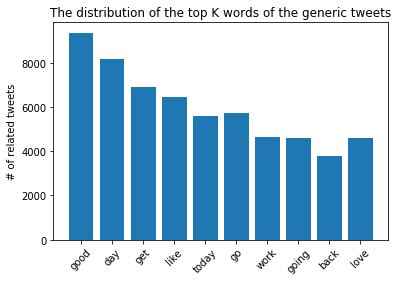

In [38]:
# plot a bar chart
l = range(len(keywords_matrix_generic.keys()))
plt.bar(l, keywords_matrix_generic.values(), align='center')
plt.xticks(l, keywords_matrix_generic.keys(), rotation=45)
plt.ylabel('# of related tweets')
plt.title('The distribution of the top K words of the generic tweets')

###### Bonus: WordCloud diagram for generic tweets top 10 words

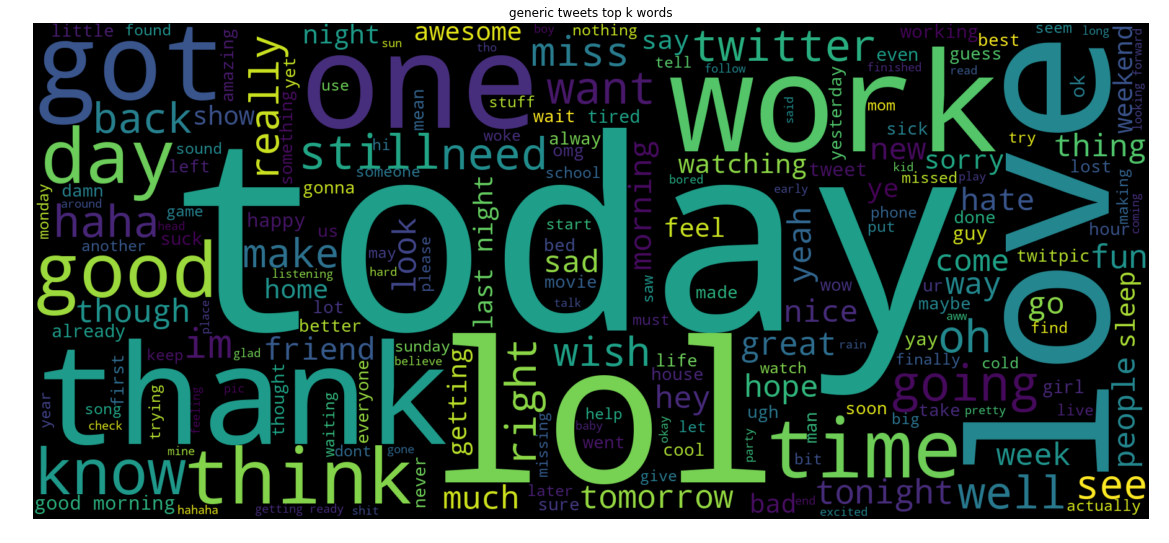

In [39]:
wl_space_split = " ".join(generic_tweet_word_list)
wordcloud = WordCloud(width = 1800, height = 800).generate(wl_space_split)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('generic tweets top k words')
plt.axis("off")
plt.show()

This bar chart give us the distribution of the top 10 words of the generic tweets.

###### Bonus: Find tweets in Generic_tweet which is related to US airline company and plot a bar chart 

Find tweets in Generic_tweet which is related to US airline company and plot a histogram

In [40]:
result_generic = fineNumOfTweetRelatedAirline(generic_tweet_df_clean, airlines_company)
result_generic

{'usairways': 1,
 'virginamerica': 0,
 'jetblue': 3,
 'southwestair': 3,
 'united': 69,
 'americanair': 0,
 'delta': 9,
 'others': 199914}

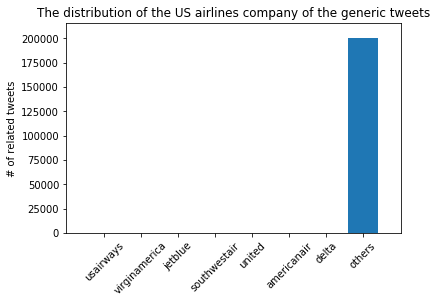

In [41]:
# plot a bar chart
l = range(len(result_generic.keys()))
plt.bar(l, result_generic.values(), align='center')
plt.xticks(l, result_generic.keys(), rotation=45)
plt.ylabel('# of related tweets')
plt.title('The distribution of the US airlines company of the generic tweets')
plt.margins(0.08)
plt.subplots_adjust(bottom=0.15)

From the diagram above, we noticed that it is meaningless to search the keyword related to US airlines company in generic tweets. Overwhelming majority of generic tweets are not related to US airline company

# 3. Model preparation

In [42]:
def corpus_count_words_improved(file_list):
    """
        The function is used to count the number of every word in file list.
        we need to tokenizer the string first, and then use counter to count every word.
        return word_counter, which includes all the words counter
    """
    tokenizer = RegexpTokenizer(r'\w+')
    word_counter = Counter()
    for file_content in file_list:
        file_words = tokenizer.tokenize(file_content)
        word_counter.update(file_words)
    return word_counter

In [43]:
def feature_selection(file_list, num_words = 2000):
    '''
        The function takes a list as input and count the word frequency of top k=2000 word in the list.
        Additionally, it also counts the word frequency in each element in the list. 
        The return result is a dataframe with word frequency and sentiment(target).
    '''
    # Calculate word count in corpus
    news_cnt = corpus_count_words_improved(file_list)
    
    # Select the most common 2000 words
    word_list = [word for (word, freq) in news_cnt.most_common(num_words)]
    
    # Create a binary encoding of dataset based on the selected features (X)
    df_rows = []
    for file_content in file_list:
        file_words = file_content.split(' ')
        df_rows.append([1 if word in file_words else 0 for word in word_list]) 
    X = pd.DataFrame(df_rows, columns = word_list)
#     X['target'] = p.Series([generic_tweet_df_clean.iloc[:,0][i]], index=X.index)
    
    # Create a dataframe of features y
    y = [0, 4]   #the polarity of each tweet (0 = negative emotion, 4 = positive emotion)
    
    return X, y

In [44]:
# Clean the generic data set first 
generic_tweet_list_cleaned = dataCleaning(generic_tweet_list)

/Users/Sharon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


In [45]:
# Clean generic data set for "text" column
generic_tweets_text

['switchfoot awww',
 'upset thatn update facebook texting might cry result school today also blah',
 'kenichan dived many times ball managed save 50 rest go bounds',
 'whole body feels itchy like fire',
 'nationwideclass',
 'kwesidei whole crew',
 'need hug',
 'loltrish hey long time see yes rains bit',
 'tatiana_k nope',
 'twittera que muera',
 'spring break plain city snowing',
 'pierced ears',
 'caregiving bear watch thought ua loss embarrassing',
 'octolinz16 counts',
 'smarrison would first',
 'iamjazzyfizzle wish got watch miss iamlilnicki premiere',
 'hollis death scene hurt severely watch film wry directors cut',
 'file taxes',
 'lettya ahh ive always wanted see rent love soundtrack',
 'fakerpattypattz oh dear drinking forgotten table drinks',
 'alydesigns day get much done',
 'one mylled',
 'angry_barista bakede ated',
 'week going hoped',
 'blagh class 8 tomorrow',
 'hate havell wake people',
 'going cry sleep watching marley',
 'im sad miss lilly',
 'ooooh lol leslie ok lesl

In [46]:
# get the features, targets dataframe
feature_df, target_df = feature_selection(generic_tweets_text)

In [47]:
feature_df.head()

,good,day,get,like,today,go,work,going,back,love,...,remembered,obviously,begin,sandwich,butter,probs,200,cloudy,hee,tennis
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
features = feature_df.as_matrix()
features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [49]:
target_df = generic_tweet_df_clean['class']
target = target_df.as_matrix()
target

array(['0', '0', '0', ..., '4', '4', '4'], dtype=object)

In [50]:
#split data ramdomly into training data(70%) and test data(30%)
feature_train, feature_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=42)

# 4. Model implementation

Train a logistic regression model on the training data and apply the model to the test data to obtain an accuracy value. 

In [51]:
def logisticRegModel(feature_train, feature_test, target_train, target_test):
    """
        The function is used to do logistic regression on training set 
        and test set and compare them to get accuracy result.
    """
    # train a logistic regression classifier
    clf = LogisticRegression(C=1.0).fit(feature_train, target_train)

    # predict on train and test set
    y_train_predict = clf.predict(feature_train)
    y_test_predict = clf.predict(feature_test)

    from sklearn.metrics import accuracy_score, confusion_matrix
    
    # calculate train and test accuracy
    train_accuracy = accuracy_score(target_train, y_train_predict)
    test_accuracy = accuracy_score(target_test, y_test_predict)

    # report results
    print("Train accuracy: {}".format(train_accuracy))
    print("Test accuracy: {}".format(test_accuracy))
    return train_accuracy, test_accuracy

In [52]:
#apply logistic regression model on generic tweets 
train_ac, test_ac = logisticRegModel(feature_train, feature_test, target_train, target_test)

Train accuracy: 0.7392624233030236
Test accuracy: 0.7339333333333333


after applying logistic regression model on generic result, which use the top 2000 words as features, we get the result for Train accuracy: 0.7392624233030236, Test accuracy: 0.7339333333333333. This model is underfit and we can use more features to improve accuracy of both train and test set.

###### Bonus: Naive Bayes classification

In [53]:
def nbModel(feature_train, feature_test, target_train, target_test):
    """
        The function is used to do logistic regression on training set 
        and test set and compare them to get accuracy result.
    """
    from sklearn.naive_bayes import GaussianNB
    # train a Naive Bayes classifier
    clf = GaussianNB().fit(feature_train, target_train)

    # predict on train and test set
    y_train_predict = clf.predict(feature_train)
    y_test_predict = clf.predict(feature_test)

    from sklearn.metrics import accuracy_score, confusion_matrix
    
    # calculate train and test accuracy
    train_accuracy = accuracy_score(target_train, y_train_predict)
    test_accuracy = accuracy_score(target_test, y_test_predict)

    # report results
    print("Train accuracy: {}".format(train_accuracy))
    print("Test accuracy: {}".format(test_accuracy))
    return train_accuracy, test_accuracy

In [54]:
#apply logistic regression model on generic tweets 
train_ac_NB, test_ac_NB = nbModel(feature_train, feature_test, target_train, target_test)

Train accuracy: 0.6792548518203702
Test accuracy: 0.6739166666666667


After comparing the result of two classifiers, we noticed that Naive Bayes is worser than logistic regression for this dataset. Because Naive Bayes assumes all the features to be conditionally independent. So, for a large feature space, if some of the features are in fact dependent on each other, the prediction might be poor. Logistic regression splits feature space linearly, and typically works reasonably well even when some of the variables are correlated. In this dataset, the feature set is large, therefore, Logistic regression will performence better than naive bayes.

Evaluate the same model on the US airline data.

In [55]:
#  get the features, targets dataframe
feature_df_us_air, target_df_us_air = feature_selection(US_airline_clean_tweets_text)

In [56]:
US_airline_clean_tweets_text

['virginamerica plus added commercials experience tacky',
 'virginamerica really aggressive blast obnoxious entertainment guests faces little recourse',
 'virginamerica really big bad thing',
 'virginamerica seriously would pay 30 flight seats playing really bad thing flying va',
 'virginamerica yes nearly every time fly vx ear worm go away',
 'virginamerica well',
 'virginamerica amazing arrived hour early good',
 'virginamerica 3 pretty graphics much better minimal iconography',
 'virginamerica great deal already thinking 2nd trip australia even gone 1st trip yet p',
 'virginamerica virginmedia flying fabulous seductive skies u take stress away',
 'virginamerica thanks',
 'virginamerica sfo pdx schedule still mia',
 'virginamerica excited first cross country flight lax mco heard nothing great things virgin 29daystogo',
 'virginamerica flew nyc sfo last week fully sit seat due two large gentleman either side help',
 'flying',
 'virginamerica know would amazingly awesome bos fll please

In [57]:
feature_df_us_air.shape

(11541, 2000)

In [58]:
features_usAir = feature_df_us_air.as_matrix()
features_usAir

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [59]:
target_df_us_air = us_airline_tweet_df_clean['sentiment']
target_usAir = target_df_us_air.as_matrix()
target_usAir

array(['positive', 'negative', 'negative', ..., 'positive', 'negative',
       'negative'], dtype=object)

In [60]:
#split data ramdomly into training data(70%) and test data(30%)
feature_train_us, feature_test_us, target_train_us, target_test_us = train_test_split(features_usAir, target_usAir, test_size=0.3, random_state=42)

In [61]:
#apply logistic regression model on us airline tweets 
train_ac_usAir, test_ac_usAir = logisticRegModel(feature_train_us, feature_test_us, target_train_us, target_test_us)

Train accuracy: 0.9520921020054469
Test accuracy: 0.9087496390412937


5. Discussion Question: How well do your predictions match the sentiment labelled in the US airline data?

From the result, we can see that if we apply the same model, it will work better on US airline tweets set. I think that is because US airline tweets set will have more useful keyword to indetify the sentiment of tweet, and the topics of it are more concentrate and similar. That's why it will have a better result than generic tweets.

Split the negative US airline tweets into training data (70%) and test data (30%). 

In [62]:
us_airline_tweet_df_clean['sentiment']

0        positive
1        negative
2        negative
3        negative
4        positive
5        positive
6        positive
7        positive
8        positive
9        positive
10       positive
11       negative
12       positive
13       negative
14       positive
15       positive
16       negative
17       positive
18       positive
19       negative
20       negative
21       negative
22       negative
23       negative
24       negative
25       negative
26       positive
27       positive
28       positive
29       negative
           ...   
11511    negative
11512    negative
11513    negative
11514    negative
11515    negative
11516    negative
11517    negative
11518    negative
11519    negative
11520    negative
11521    positive
11522    negative
11523    positive
11524    negative
11525    negative
11526    negative
11527    positive
11528    negative
11529    positive
11530    negative
11531    negative
11532    positive
11533    negative
11534    positive
11535    n

In [63]:
# count how many negative tweets in US_airline tweets set and append the indext of that tweet into a list
def negUsAirTweets(us_airline_tweet_df_clean, thred = 'negative'):
    List_negUsAirTweets = []
    for i in range(len(us_airline_tweet_df_clean['sentiment'])):
        if us_airline_tweet_df_clean['sentiment'][i] == thred:
            List_negUsAirTweets.append(i)
    return List_negUsAirTweets

In [64]:
list_index_negUsAirTweets = negUsAirTweets(us_airline_tweet_df_clean) 

In [65]:
len(list_index_negUsAirTweets)

9178

In [66]:
us_airline_tweet_df_clean.loc[1,'sentiment']

'negative'

In [67]:
def blurPositive(rating_df):
    """
        The function is used to blur the positive tweets in us airline tweets.
        we will return a new dataframe only contains negtive tweets
    """
    rows_list = []
    new_df = pd.DataFrame(columns=['id', 'sentiment', 'negative_reason', 'user', 'retweet_count','text'])
    n = 0
    for i in range(len(rating_df['sentiment'])):
        if rating_df.loc[i,'sentiment'] == 'negative':
            rows_list.append(rating_df.loc[i,:])
    new_df = pd.DataFrame(rows_list) 
    return new_df

In [68]:
# return data frame only contains negative feedback
Neg_USAir_df = blurPositive(us_airline_tweet_df_clean)

In [69]:
Neg_USAir_df.head()

,id,sentiment,negative_reason,user,retweet_count,text
1,5.703010e+17,negative,Bad Flight,jnardino,0,virginamerica really aggressive blast obnoxiou...
2,5.703010e+17,negative,Can't Tell,jnardino,0,virginamerica really big bad thing
3,5.703010e+17,negative,Can't Tell,jnardino,0,virginamerica seriously would pay 30 flight se...
11,5.702820e+17,negative,Late Flight,smartwatermelon,0,virginamerica sfo pdx schedule still mia
13,5.702770e+17,negative,Bad Flight,heatherovieda,0,virginamerica flew nyc sfo last week fully sit...


In [70]:
# cleaning the negative reason list
neg_reason_clean_list = dataCleaning(Neg_USAir_df['negative_reason'].tolist())

/Users/Sharon/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The unescape method is deprecated and will be removed in 3.5, use html.unescape() instead.


In [71]:
neg_reason_clean_list

['bad flight',
 'tell',
 'tell',
 'late flight',
 'bad flight',
 'tell',
 'customer service issue',
 'customer service issue',
 'tell',
 'bad flight',
 'flight booking problems',
 'customer service issue',
 'customer service issue',
 'customer service issue',
 'flight booking problems',
 'flight booking problems',
 'customer service issue',
 'customer service issue',
 'late flight',
 'lost luggage',
 'flight attendant complaints',
 'customer service issue',
 'customer service issue',
 'late flight',
 'tell',
 'tell',
 'flight booking problems',
 'tell',
 'cancelled flight',
 'late flight',
 'customer service issue',
 'customer service issue',
 'tell',
 'flight booking problems',
 'customer service issue',
 'late flight',
 'late flight',
 'late flight',
 'customer service issue',
 'flight booking problems',
 'late flight',
 'customer service issue',
 'flight booking problems',
 'customer service issue',
 'customer service issue',
 'customer service issue',
 'tell',
 'cancelled flight',


In [72]:
def getTeNegReason(neg_reason_clean_list):
    """
        The function is used to get all the negative reasons in neg_reason_clean_list,
        each reason will appear one time in new list.
    """
    res_list = []
    for res in neg_reason_clean_list:
        if res not in res_list:
            res_list.append(res)
            
    return res_list

In [73]:
# return the list of negative reason
negREs_list = getTeNegReason(neg_reason_clean_list)
negREs_list

['bad flight',
 'tell',
 'late flight',
 'customer service issue',
 'flight booking problems',
 'lost luggage',
 'flight attendant complaints',
 'cancelled flight',
 'damaged luggage',
 'longlines']

In [74]:
#  get the features, targets dataframe
feature_df_usAir_ne, target_df_usAir_ne = feature_selection(Neg_USAir_df['text'])

In [75]:
feature_df_usAir_ne.shape

(9178, 2000)

In [76]:
features_usAir_ne = feature_df_usAir_ne.as_matrix()
features_usAir_ne

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [77]:
target_df_us_air_ne = Neg_USAir_df['negative_reason']
target_usAir_ne = target_df_us_air_ne.as_matrix()
target_usAir_ne

array(['Bad Flight', "Can't Tell", "Can't Tell", ..., 'Late Flight',
       'Customer Service Issue', 'Customer Service Issue'], dtype=object)

In [78]:
#split data ramdomly into training data(70%) and test data(30%)
feature_train_us_ne, feature_test_us_ne, target_train_us_ne, target_test_us_ne = train_test_split(features_usAir_ne, target_usAir_ne, test_size=0.3, random_state=42)

In [79]:
#apply logistic regression model on negative us airline tweets 
train_ac_usAir_ne, test_ac_usAir_ne = logisticRegModel(feature_train_us_ne, feature_test_us_ne, target_train_us_ne, target_test_us_ne)

Train accuracy: 0.8317247820672479
Test accuracy: 0.6053013798111837


After applying logistic regression on negative us airline tweets set, using negative reason as target, and top 2000 words as features. the result is Train accuracy: 0.8317247820672479, Test accuracy: 0.6053013798111837. It is obvious that the model is overfit, which means that it predict very well on training set, but it is not good for test set. We can reduce the number of features to improve it.

# 5. Discussion

some of the questions are answered before, please see part 2, 3 and 4.

In [80]:
target_test_us_ne

array(['longlines', 'Late Flight', 'Customer Service Issue', ...,
       "Can't Tell", 'Customer Service Issue', 'Damaged Luggage'],
      dtype=object)

In [81]:
feature_test_us_ne

array([[1, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [82]:
def random_cm(X, y, num_tests):
    # cm_list is a list of confusion matrices for the different random splits of the dataset
    cm_list = []

    # Write your code here
    for i in range(num_tests):
    
        # split to train and test set
        import random
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random.randint(1,1000))

        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train)
        y_test_predict = clf.predict(X_test)
        
        cm = confusion_matrix(y_test, y_test_predict)
        cm_list.append(cm)
    
    # sum the confusion matrices and return the combined confusion matrix
    combined_cm = pd.Panel(cm_list).sum(axis=0)
    
    # validate return type
    assert isinstance(combined_cm, pd.DataFrame), "return type"
    
    return combined_cm

In [83]:
def plot_confusion_matrix(cm):
    # plot the confusion matrix
    plt.figure(figsize=(10,10))
    plt.matshow(cm, fignum=1)
    
    # add labels for all targets
    num_targets = cm.shape[0]
    plt.xticks(list(range(num_targets+1)))
    plt.yticks(list(range(num_targets+1)))

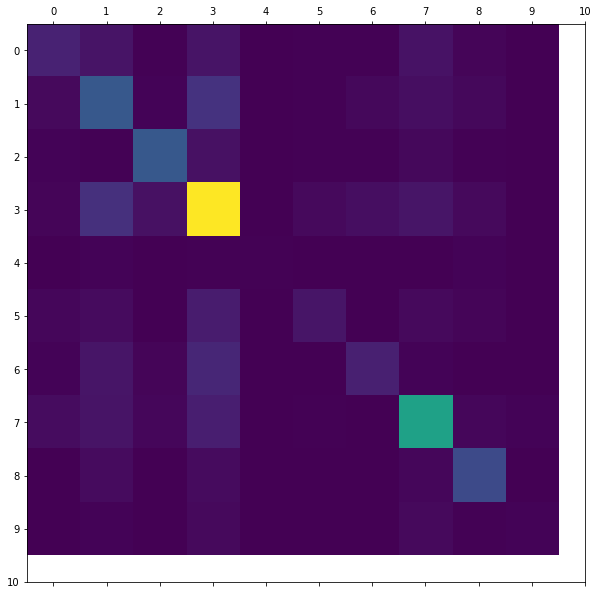

In [84]:
cm10 = random_cm(feature_df_usAir_ne, target_usAir_ne, num_tests = 1)
plot_confusion_matrix(cm10)

In [85]:
negREs_list

['bad flight',
 'tell',
 'late flight',
 'customer service issue',
 'flight booking problems',
 'lost luggage',
 'flight attendant complaints',
 'cancelled flight',
 'damaged luggage',
 'longlines']

From the Confusion matrix diagram, we can see that the negative reason 'customer service issue' and 'tell' are very confused to each other. The reason is that most features of those two target are overlapped with each other's features and for 'flight booking problems' and 'longlines', those are really bad pridictions, because they connot pridict correctly, from the diagram, we can see that the color of [4,4] and [9,9] squres are not obvious. The deeper color of squre means larger number of item fits into that target, so when x and y is same number, the color of it should be very deep(good performance), therefore, 'flight booking problems' and 'longlines' are bad negative reason and fail to predict using this model. The reason of it is that, it is a multi-class model, there are 10 class in my design. Some of the class should be combine together, for example, 'flight attendant complaints' and 'late flight' are similar reason, we can combine them together to receive better result. And the number of features that we choose is 2000, it is too much will cause overfitting problem. Therefore, the suggestion to improve accuracy is to reduce the class size, combine some similar reasons together, and reduce feature sets, prevent overfitting.

###### Bonus: Improve the performance of your model by tuning size of Feature Set.

In [86]:
def feature_num(X, y):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    for p in [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]:
        subset_size = int(p*X.shape[1])
        X_train_subset = X_train.iloc[:, 0:subset_size]
        X_test_subset = X_test.iloc[:, 0:subset_size]     
        # train a logistic regression classifier
        clf = LogisticRegression(C=1.0).fit(X_train_subset, y_train)

        # predict on train and test set
        y_train_predict = clf.predict(X_train_subset)
        y_test_predict = clf.predict(X_test_subset)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(y_train, y_train_predict)
        test_accuracy = accuracy_score(y_test, y_test_predict)

        # add to result_list
        result_list.append((p, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["num_features", "train_accuracy", "test_accuracy"])
    
    return result_df

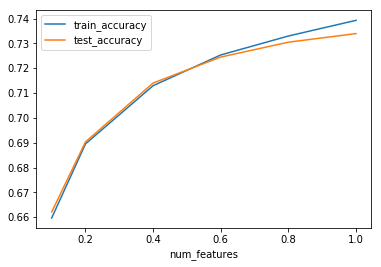

In [87]:
feature_num_df = feature_num(feature_df, target_df)
feature_num_df.plot(x="num_features", y=["train_accuracy", "test_accuracy"])

The trend showing up in the graph is that if increase the amount of feature set will increase the accuracy of both train set and test set. Use more features we can get more accurate results

###### Bonus: Improve the performance of your model by tuning its Hyperparameter

In [88]:
def hyperparameter(feature_train, feature_test, target_train, target_test):
    # result_list is a list of tuples (num_features, train_accuracy, test_accuracy)
    # where numFeatures is the number of words used as features
    result_list = []
    
    for param in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:    
        # train a logistic regression classifier
        clf = LogisticRegression(C=param).fit(feature_train, target_train)

        # predict on train and test set
        target_train_predict = clf.predict(feature_train)
        target_test_predict = clf.predict(feature_test)

        # calculate train and test accuracy
        train_accuracy = accuracy_score(target_train, target_train_predict)
        test_accuracy = accuracy_score(target_test, target_test_predict)
        
        # add to result_list
        result_list.append((param, train_accuracy, test_accuracy))
        
    # Make a dataframe of the results
    result_df = pd.DataFrame(result_list, columns=["param", "train_accuracy", "test_accuracy"])
    
    return result_df

In [89]:
result_df = hyperparameter(feature_train, feature_test, target_train, target_test)

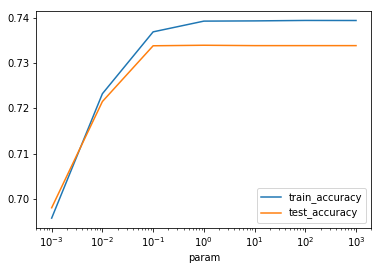

In [90]:
result_df.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

In [91]:
result_df_us = hyperparameter(feature_train_us, feature_test_us, target_train_us, target_test_us)

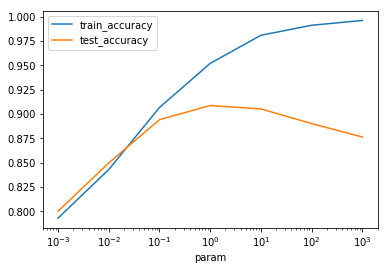

In [92]:
result_df_us.plot(x="param", y=["train_accuracy", "test_accuracy"], logx=True)

C in logistic regression means the inverse of regularization strength. It must be a positive float. Smaller values specify stronger regularization. For small values of C, we increase the regularization strength which will create simple models which underfit the data. For big values of C, we lower the power of regularization which imples the model is allowed to overfit the data. The trend showing up in the graph is that when C is 0.1, test accuracy will reach the highest point. If continue increasing C, the accuracy of test set will decrease. For the train set, if increasing the number of C, the accuracy will increase as well.